In [3]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/15-38-19" # un-conditioned - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/17-33-19" # one-hot - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/proteoscope/2023-08-10/16-11-37" # mean
BASE_DIR = "/home/ec2-user/outputs-proteoscope/proteoscope/2023-08-11/05-38-13" # mean
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/16-34-38" # 25 x 25 cond latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/22-36-50" # 25 x 25 cond nuclei + latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-05/01-50-26" # 25 x 25 cond nuclei + latent

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size // 2,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding
    )
    pdm.setup()

    plm = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=1,
    )

    plm.unet.eval()
    plm.unet.cuda()
    plm.autoencoder.cuda()

/tmp/ipykernel_4523/560186824.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/proteoscope/2023-08-11/05-38-13/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:40: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)


In [4]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)

In [5]:
# pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [2]:
# pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels[pdm.val_proteins_dataset.labels['localization'] != '']
dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [3]:
# pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
# dl = pdm.train_dataloader()

In [4]:
# dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [6]:
# from tqdm import tqdm

# outputs = []
# locs = []

# # batch = next(iter(dl))
# # cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()

# for batch in tqdm(dl):
#     output = plm.sample(batch, cond_scale=3, cond_images=None).detach().cpu().numpy()

#     # vq_outputs = plm.cytoself_model.vq_layers[1](output_encoded_images)
#     # output_vqvae2 = vq_outputs[1].detach().cpu().numpy()
    
#     locs.append(np.array(batch['localization']))
#     outputs.append(output)
#     # outputs.append(output_encoded_images.detach().cpu().numpy())
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)

In [7]:
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)
# inputs = np.concatenate(inputs, axis=0)

In [6]:
from tqdm import tqdm
import torch

true_images = []
true_localizations = []
predicted_images = []
predicted_latents = []
true_latents = []

# batch = next(iter(dl))
# cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()
for _ in range(1):
    for batch in tqdm(dl):
        batch['image'] = batch['image'].cuda()

        predicted_latent = plm.sample(batch, guidance_scale=3, cond_images=None)
        predicted_image = plm.autoencoder.decode(predicted_latent).sample
        true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean
        
        true_localizations.append(np.array(batch['localization']))

        true_images.append(batch['image'].detach().cpu().numpy())
        true_latents.append(true_latent.detach().cpu().numpy())
        predicted_latents.append(predicted_latent.detach().cpu().numpy())
        predicted_images.append(predicted_image.detach().cpu().numpy())

predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)

  0%|          | 0/6641 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 1/6641 [00:13<25:03:29, 13.59s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 2/6641 [00:23<21:26:35, 11.63s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 3/6641 [00:34<20:18:57, 11.02s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 4/6641 [00:44<19:48:44, 10.75s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 5/6641 [00:54<19:33:08, 10.61s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 6/6641 [01:05<19:23:23, 10.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 7/6641 [01:15<19:19:14, 10.48s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 8/6641 [01:25<19:14:06, 10.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 9/6641 [01:36<19:13:54, 10.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 10/6641 [01:46<19:12:41, 10.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 11/6641 [01:57<19:10:44, 10.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 12/6641 [02:07<19:10:56, 10.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 13/6641 [02:18<19:11:27, 10.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 14/6641 [02:28<19:11:26, 10.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 15/6641 [02:38<19:12:35, 10.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 16/6641 [02:49<19:14:35, 10.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 17/6641 [02:59<19:16:11, 10.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 18/6641 [03:10<19:14:33, 10.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 19/6641 [03:20<19:14:50, 10.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 20/6641 [03:31<19:14:30, 10.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 21/6641 [03:41<19:12:42, 10.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 22/6641 [03:52<19:10:22, 10.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 23/6641 [04:02<19:11:43, 10.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 24/6641 [04:12<19:11:21, 10.44s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 25/6641 [04:23<19:07:56, 10.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 26/6641 [04:33<19:08:09, 10.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 27/6641 [04:44<19:09:10, 10.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 27/6641 [04:49<19:40:05, 10.71s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   for batch in tqdm(dl):                                                                  │
│   14 │   │   batch['image'] = batch['image'].cuda()                                              │
│   15 │   │                                                                                       │
│ ❱ 16 │   │   predicted_latent = plm.sample(batch, guidance_scale=3, cond_images=None)            │
│   17 │   │   predicted_image = plm.autoencoder.decode(predicted_latent).sample                   │
│   18 │   │   true_latent = plm.autoencoder.encode(batch['image']).latent_dist.mean               │
│   19                                                                                             │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/proteoscopemodule.py:212 in sample                        │
│                                                                                                  │
│   209 │   │   │                                                                                  │
│   210 │   │   │   # predict the noise residual                                                   │
│   211 │   │   │   with torch.no_grad():                                                          │
│ ❱ 212 │   │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=seq_   │
│   213 │   │   │                                                                                  │
│   214 │   │   │   # perform guidance                                                             │
│   215 │   │   │   noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)                       │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1190 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:905 in │
│ forward                                                                                          │
│                                                                                                  │
│   902 │   │   down_block_res_samples = (sample,)                                                 │
│   903 │   │   for downsample_block in self.down_blocks:                                          │
│   904 │   │   │   if hasattr(downsample_block, "has_cross_attention") and downsample_block.has   │
│ ❱ 905 │   │   │   │   sample, res_samples = downsample_block(                                    │
│   906 │   │   │   │   │   hidden_states=sample,            

In [7]:
predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)

In [8]:
# print(predicted_images.shape)
print(predicted_latents.shape)

(432, 16, 12, 12)


In [9]:
import matplotlib.pyplot as plt

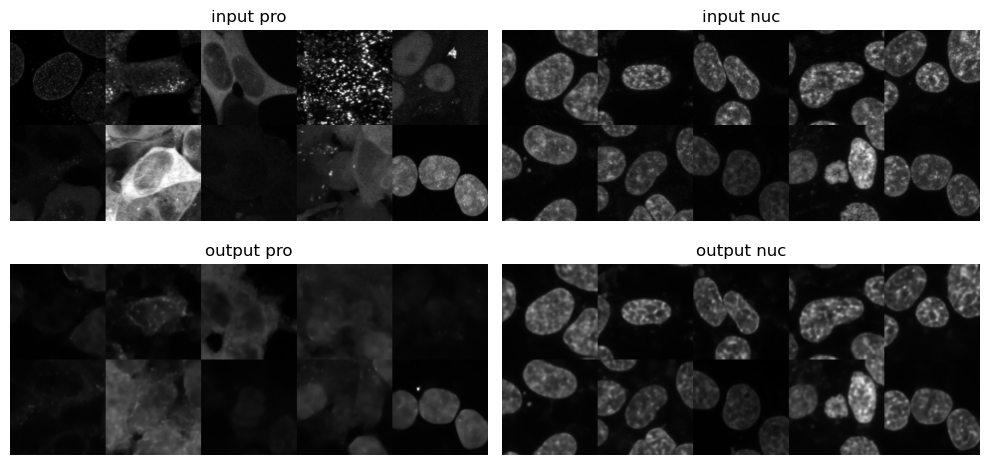

In [10]:
size = true_images.shape[-1]
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * size, 5 * size))
    for i, im in enumerate(true_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
    t1 = np.zeros((2 * size, 5 * size))
    for i, im in enumerate(predicted_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [11]:
from ipywidgets import interact

In [42]:
def browse_images(true_images, predicted_images):
    n = len(true_images) // 10
    def view_image(jj):
        size = true_images.shape[-1]
        data_ch = ['pro', 'nuc']
        fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
        for ii, ch in enumerate(data_ch):
            t0 = np.zeros((2 * size, 5 * size))
            for i, im in enumerate(true_images[jj*10:jj*10+10, ii, ...]):
                i0, i1 = np.unravel_index(i, (2, 5))
                t0[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
            t1 = np.zeros((2 * size, 5 * size))
            for i, im in enumerate(predicted_images[jj*10:jj*10+10, ii, ...]):
                i0, i1 = np.unravel_index(i, (2, 5))
                t1[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
            ax[0, ii].imshow(t0, cmap='gray')
            ax[0, ii].axis('off')
            ax[0, ii].set_title('input ' + ch)
            ax[1, ii].imshow(t1, cmap='gray')
            ax[1, ii].axis('off')
            ax[1, ii].set_title('output ' + ch)
    interact(view_image, jj=(0,n-1))

In [43]:
browse_images(true_images, predicted_images)

interactive(children=(IntSlider(value=21, description='jj', max=42), Output()), _dom_classes=('widget-interact…

In [46]:
def merge_images(img_A, img_B):
    rgb = np.tile(img_A, (3, 1, 1)).transpose(1, 2, 0)
    rgb[:, :, 1] = img_B
    return np.clip(rgb, 0, 1)

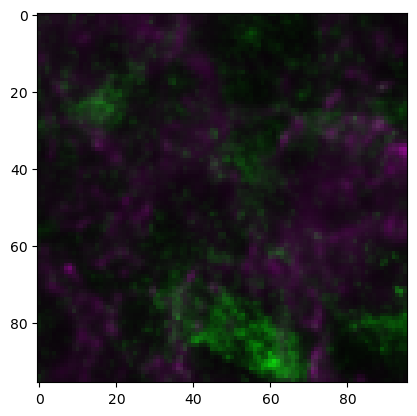

In [47]:
id = 40

plt.imshow(merge_images(predicted_images[id, 0], true_images[id, 0]))

In [79]:
def browse_merge_images(true_images, predicted_images):
    n = len(true_images)
    def view_image(jj):
        fig, ax = plt.subplots(1, 3, figsize=(12, 12), squeeze=False)
        ax[0, 0].imshow(merge_images(predicted_images[jj, 0], true_images[jj, 0]))
        ax[0, 0].axis('off')
        ax[0, 1].imshow(true_images[jj, 0])
        # ax[0, 1].imshow(merge_images(true_images[jj, 0], true_images[jj, 1]))
        ax[0, 1].axis('off')
        # ax[0, 2].imshow(merge_images(predicted_images[jj, 0], predicted_images[jj, 1]))
        ax[0, 2].imshow(predicted_images[jj, 0])
        ax[0, 2].axis('off')
    interact(view_image, jj=(0,n-1))

In [80]:
browse_merge_images(true_images, predicted_images)

interactive(children=(IntSlider(value=215, description='jj', max=431), Output()), _dom_classes=('widget-intera…

# Cytoself

In [81]:
import zarr
import numpy as np
from os.path import join

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "embeddings_2.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "localizations_2.npy"))

In [82]:
from joblib import load

reducer = load(join(datapath,'umap_model_2.joblib'))

In [83]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'

In [84]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

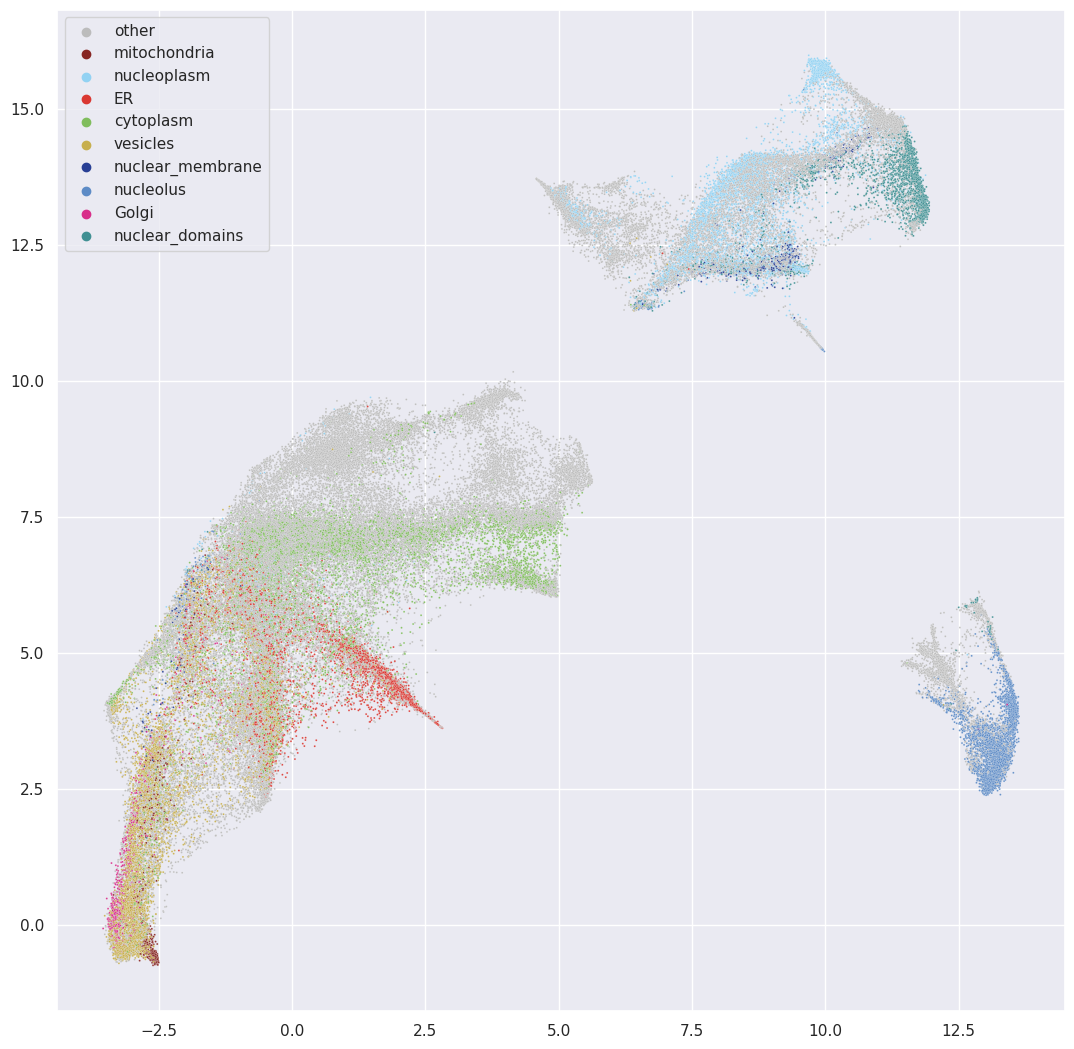

In [85]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [86]:
reduced_outputs = reducer.transform(predicted_latents.reshape(predicted_latents.shape[0], -1))
reduced_locs = true_localizations
reduced_locs[reduced_locs == ''] = 'other'

<AxesSubplot:>

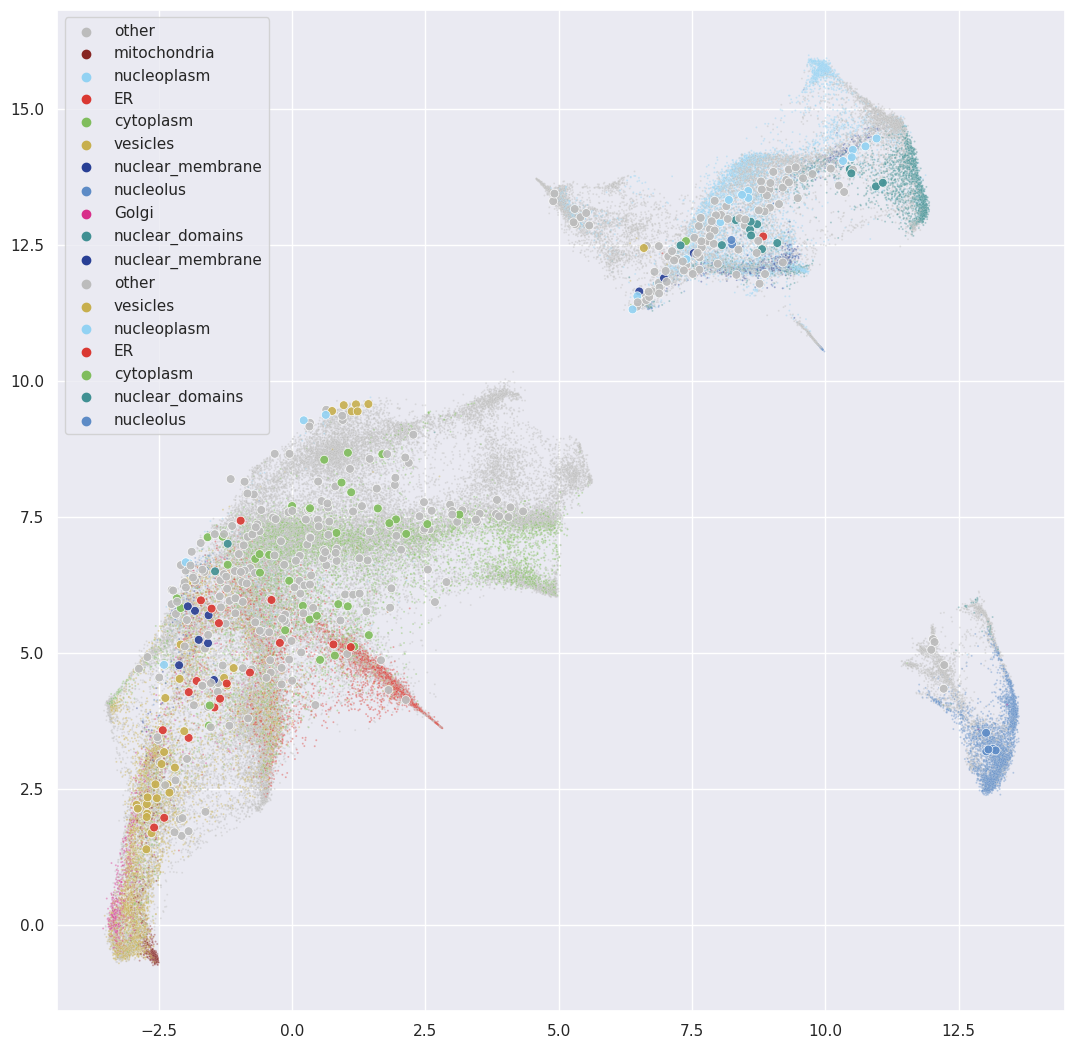

In [87]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [88]:
print(embeddings.max())
print(embeddings.min())
print(predicted_latents.max())
print(predicted_latents.min())

10.501887321472168
-7.183016777038574
7.6326647
-5.7398767


In [16]:
reduced_true_outputs = reducer.transform(true_latents.reshape(true_latents.shape[0], -1))

<AxesSubplot:>

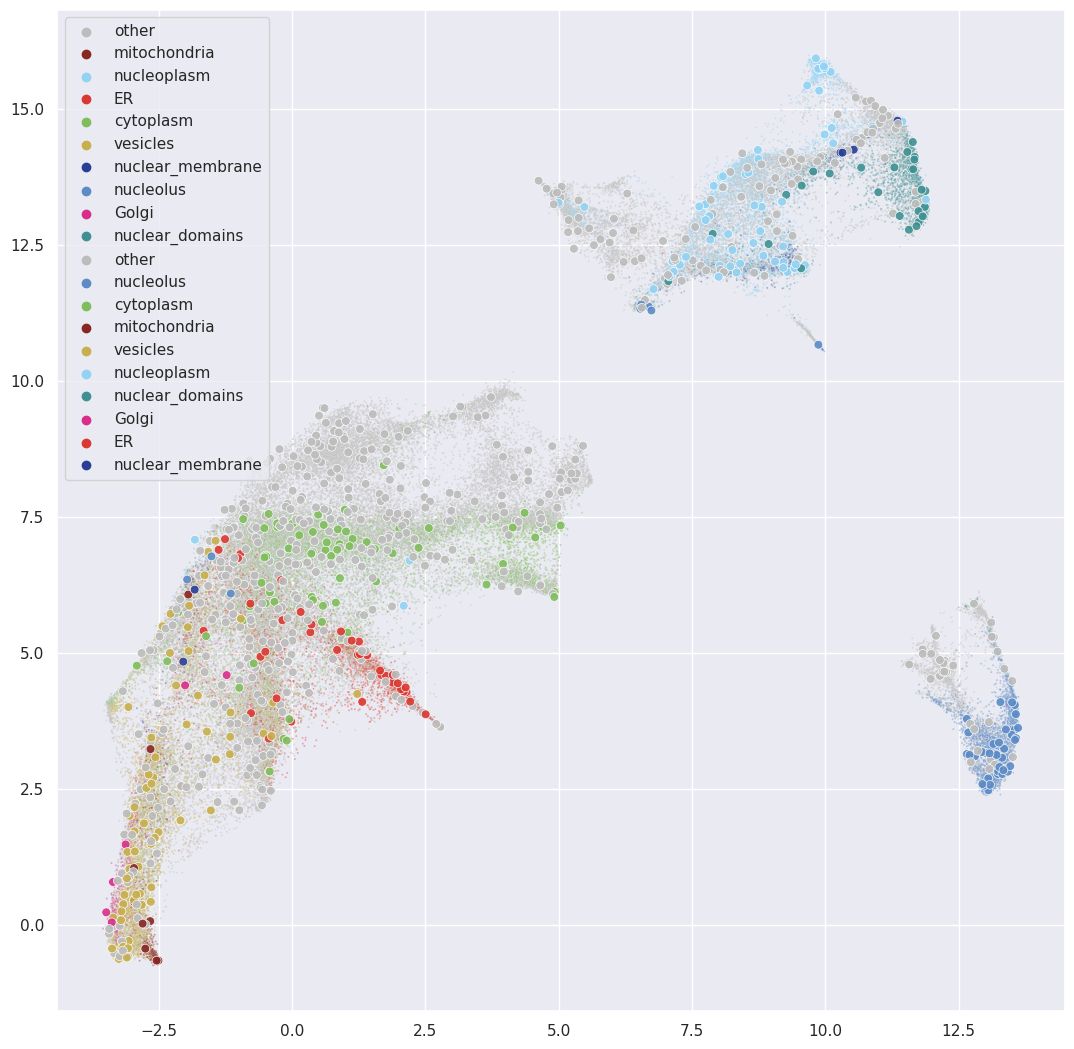

In [17]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_true_outputs[:, 0], y=reduced_true_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

### Classifications

In [89]:
from joblib import load

# Load the model from the file
clf = load(join(datapath,'localization_classifier_2.joblib'))


In [96]:
other = true_localizations == 'other'
X_test = predicted_latents[~other]
X_test = true_latents[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [97]:
true_latents.shape

(432, 16, 12, 12)

In [98]:
y_predict = clf.predict(X_test)

In [99]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# class_labels = np.unique(localizations[localizations != 'other'])
class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.8613138686131386


In [100]:
import matplotlib.pyplot as plt

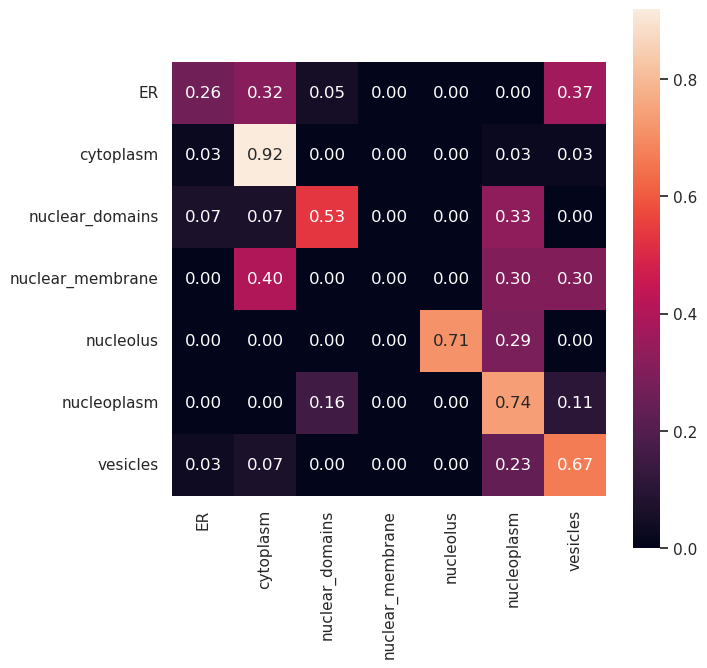

In [95]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

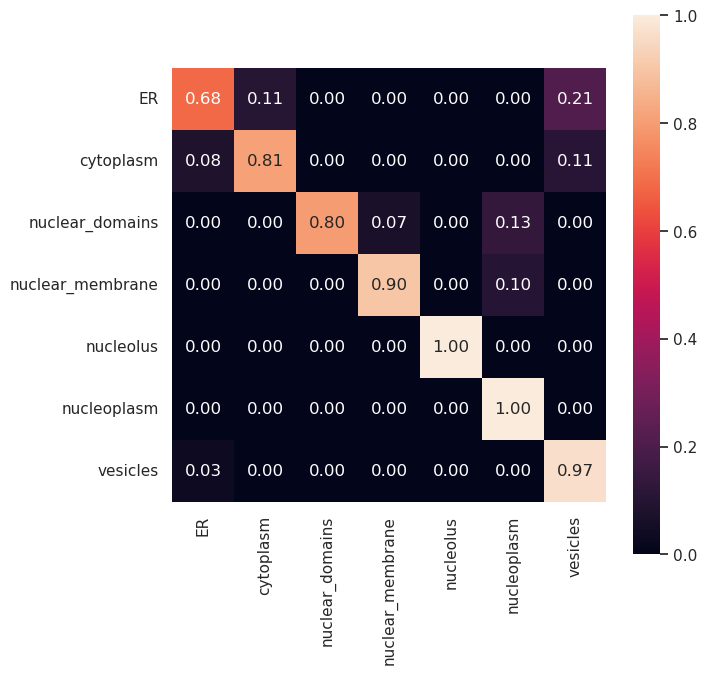

In [101]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Latent space position

In [105]:
all_latents = np.concatenate([true_latents, embeddings])

In [109]:
predicted_latents.shape

(432, 16, 12, 12)

In [110]:
distances = np.linalg.norm(all_latents - predicted_latents, axis=1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 distances = np.linalg.norm(all_latents - predicted_latents, axis=1)                          │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: operands could not be broadcast together with shapes (92257,16,12,12) (432,16,12,12)

In [116]:
!conda install -c pytorch -c nvidia faiss-gpu=1.7.4 mkl=2021 blas=1.0=mkl

failed

CondaError: KeyboardInterrupt



In [1]:
import faiss
import numpy as np


def closest_vectors_faiss(A, B, k=10):
    """
    For each vector in B, find the indices of the k closest vectors in A using faiss.
    """
    A = A.reshape(A.shape[0], -1).astype('float32')
    B = B.reshape(B.shape[0], -1).astype('float32')
    
    # Initialize index
    dimension = A.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(A)
    
    # Search the index for each vector in B
    _, indices = index.search(B, k)
    
    # Return the list of indices
    return indices.tolist()

# Example
A = [[1, 2], [3, 4], [5, 6], [2, 3], [4, 5], [6, 7], [1, 3], [2, 4], [3, 5], [5, 7], [4, 6]]
B = [[3, 3], [5, 5.5]]

print(closest_vectors_faiss(A, B, 10))


ModuleNotFoundError: No module named 'faiss'

## ESM localization baseline

In [64]:
pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.train_dataloader()


In [68]:
pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=True, shuffle=False)

In [69]:
from tqdm import tqdm
import torch

sequence_embeddings = []
true_localizations = []
for batch in tqdm(dl):    
    true_localizations.append(np.array(batch['localization']))
    sequence_embeddings.append(batch['sequence_embed'].detach().cpu().numpy())

true_localizations = np.concatenate(true_localizations, axis=0)
sequence_embeddings = np.concatenate(sequence_embeddings, axis=0)

100%|██████████| 5/5 [00:00<00:00,  6.03it/s]


In [67]:
embeddings_train = sequence_embeddings[:, 0, :]
localizations_train = true_localizations

In [70]:
embeddings = sequence_embeddings[:, 0, :]
localizations = true_localizations

In [73]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == ''
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == ''
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [83]:
np.unique(y_test)

array(['ER', 'cytoplasm', 'nuclear_domains', 'nuclear_membrane',
       'nucleolus', 'nucleoplasm', 'vesicles'], dtype='<U16')

In [78]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
from joblib import load
from joblib import dump

# Save the model to a file
dump(clf, join(datapath,'localization_classifier_esm.joblib'))

# # Load the model from the file
# clf = load(join(datapath,'localization_classifier_esm.joblib'))


['/home/ec2-user/autoencoder-data/localization_classifier_esm.joblib']

In [80]:
y_predict = clf.predict(X_test)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.5111111111111111


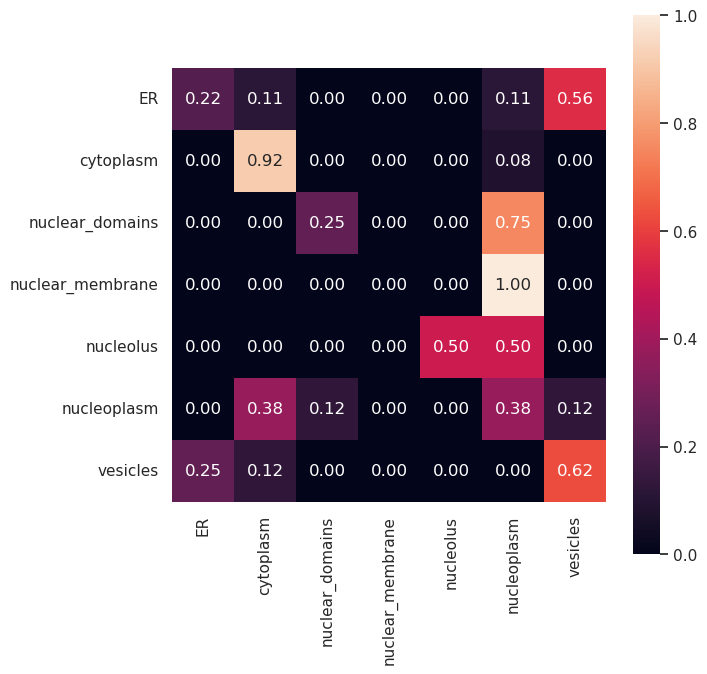

: 

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

## Combined classification